In [61]:
import numpy as np
import pandas as pd 
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import seaborn as sns
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import pickle
import collections

In [2]:
ImageList = "/datasets/sagarj/streetView/fringeImages.csv"
imgList = pd.read_csv(ImageList)

In [3]:
AMImages = "/datasets/sagarj/streetView/Transform_Random/"

In [4]:
files = os.listdir(AMImages)

In [5]:
len(files)

501

In [6]:
filesMap = {}
for f in files:
    comps = f.strip().split('_')
    filesMap[comps[0]] = {}
    filesMap[comps[0]]['path'] = AMImages + f
    filesMap[comps[0]]['act'] = comps[2]
    filesMap[comps[0]]['changeLabel'] = comps[1][-1]

In [7]:
len(filesMap.keys())

250

In [8]:
for index , row in imgList[:500].iterrows():
    if row['key'] in filesMap.keys():
        filesMap[row['key']]['origPath'] = row['path']
        filesMap[row['key']]['label'] = row['label']

In [9]:
#filesMap

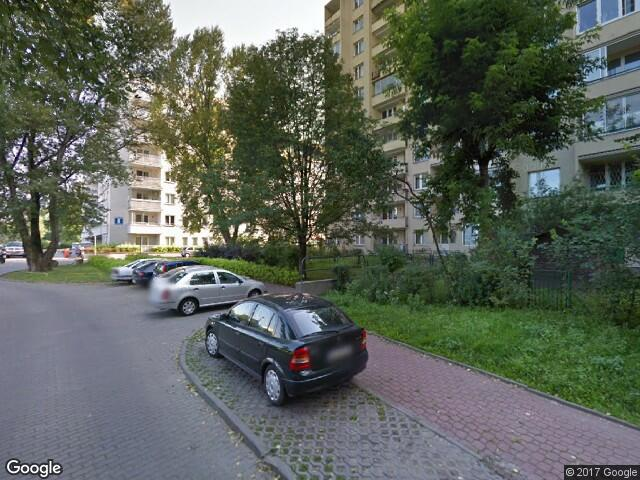

In [10]:
Image(filesMap['50f42c7dfdc9f065f0001d54']['origPath'])

In [11]:
filesMap['50f42c7dfdc9f065f0001d54']['changeLabel']

'0'

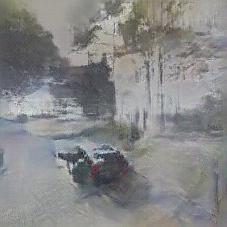

In [12]:
Image(filesMap['50f42c7dfdc9f065f0001d54']['path'])

In [13]:
import caffe
import sys
import os

import random
import numpy as np
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm

import cv2


# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

model_root = "/datasets_1/sagarj/BellLabs/caffe_models/places/"

imagenet_mean = model_root + 'places205CNN_mean.binaryproto'

logfile = "../Data/PlacesFeatExtractStreetview.txt"


#Size of images
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def predictImage(imgPath , net, transformer):
    

    path = imgPath.strip()
    im = caffe.io.load_image(path)
    net.blobs['data'].data[...] = transformer.preprocess('data', im)
    net.forward()
    #out1 = net.blobs['prob'].data
    out2 = net.blobs['fc7'].data
    #print(out2.shape)
    #out = np.concatenate((out1,out2.reshape(1,-1)),axis =1)
    out = out2
    #print(out.shape)
    return out


    
def getFeatMatrix(DataDict):
    caffe.set_mode_gpu()    
    model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    feats = {}
    for k in DataDict:
        path = DataDict[k]['origPath'].strip()
        if not os.path.exists(path):
            featArray = np.zeros((1,4096))
        else:
            im = caffe.io.load_image(path)
            net.blobs['data'].data[...] = transformer.preprocess('data', im)
            net.forward()
            featArray = net.blobs['fc7'].data.copy()
                
        DataDict[k]['placesFeats'] = featArray
    return DataDict

In [14]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u.flatten(), v2_u.flatten()), -1.0, 1.0))

In [15]:
transformedFilesMap = getFeatMatrix(filesMap)

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [16]:
transformedFilesMap[transformedFilesMap.keys()[151]]

{'act': '0.348198',
 'changeLabel': '0',
 'label': 1,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/50f448a4fdc9f065f00040ba.jpg',
 'path': '/datasets/sagarj/streetView/Transform_Random/50f448a4fdc9f065f00040ba_0000_0.348198_.jpg',
 'placesFeats': array([[ 0.        ,  0.32939303,  0.        , ...,  0.        ,
          0.18854463,  0.        ]], dtype=float32)}

# This is an extremely shitty part of the code. The crux is you need the test data in a key : dict{} format where the dict should have a 'origPath' entry with the path of the test image which we are retrevi

In [17]:
with open("../Data/TrainImageListBinary_augmented.txt",'r') as f:
    imagePaths = f.readlines()

In [18]:
sampledpaths = random.sample(imagePaths , 5000)

In [19]:
dataFileMap = {}
for p in sampledpaths:
    path = p.strip().split(',')[0]
    key = path.split('/')[-1].split('.')[0][:-1]
    dataFileMap[key] = {}
    dataFileMap[key]['origPath'] = path

In [20]:
retreivalFileMap = getFeatMatrix(dataFileMap)

# End shitty zone now. the next sections are about matching

In [21]:
distanceMapper = {}
for k in filesMap:
    distanceMapper[k] = {}
    for i in retreivalFileMap:
        distanceMapper[k][i] = angle_between(filesMap[k]['placesFeats'] , retreivalFileMap[i]['placesFeats'])

In [22]:
len(distanceMapper.keys())

250

In [25]:
distanceMapper[distanceMapper.keys()[0]]

{'5140ca1cfdc9f0492600272f': 1.1251681,
 '50f5e701fdc9f065f0006f0d': 0.88843501,
 '5185d126fdc9f03fd50010a5': 1.1632195,
 '513f13f1fdc9f0358700cb97': 1.2240239,
 '50f5ebacfdc9f065f000846': 1.1182845,
 '50e748ead7c3df413b00148': 1.1670769,
 '50f5e8e4fdc9f065f00075c1': 1.2387469,
 '513cc130fdc9f03587001458': 1.0467317,
 '51414848fdc9f04926006c64': 1.1596152,
 '50f39820fdc9f065f0000e1': 1.1780285,
 '513f14d2fdc9f0358700ccd6': 1.3119375,
 '513cc4d2fdc9f035870017d': 1.2179728,
 '50f561ccfdc9f065f000575b': 0.87659943,
 '51414de7fdc9f049260076f': 1.2260156,
 '50f61676beb2fed9100008cf': 1.0388917,
 '514139fefdc9f049260055d6': 1.0840561,
 '51409c9dfdc9f049260011fb': 1.2102916,
 '50f60c4bbeb2fed91000025': 1.2508366,
 '513d9df4fdc9f03587008252': 0.95590764,
 '50f5ebaffdc9f065f0008499': 1.292854,
 '513d9df4fdc9f03587008254': 0.91521311,
 '5140d97afdc9f04926003c01': 1.1619707,
 '5140d827fdc9f0492600395b': 1.0866611,
 '50f46440fdc9f065f000443': 1.1634748,
 '513e5bc8fdc9f0358700a942': 1.2349451,
 '51

In [26]:
import operator
top5s = {}
for k in distanceMapper:
    top5s[k]=sorted(distanceMapper[k].items(), key=operator.itemgetter(1))[:5]
    

In [27]:
top5s[top5s.keys()[1]]

[('5140ca1cfdc9f0492600272f', 0.64859194),
 ('50f5ed68fdc9f065f0008d2', 0.67963797),
 ('513e218afdc9f0358700a45a', 0.71530491),
 ('50f43523fdc9f065f0002b8', 0.71856529),
 ('514226f1fdc9f049260085f5', 0.7263031)]

In [28]:
index = pd.Series(range(len(filesMap.keys())))
column = ['key' , 'origPath' ,'XformPath' , 'Top5Keys' , 'Top5Paths']

In [29]:
retreivedDf = pd.DataFrame( columns=column )

In [30]:
for k in filesMap:
    top5Keys = [p[0] for p in top5s[k]]
    top5Paths = [dataFileMap[p[0]]['origPath'] for p in top5s[k]]
    origPath = filesMap[k]['origPath']
    xformPath = filesMap[k]['path']
    d = pd.DataFrame({'key' : k , 'origPath' : origPath ,'XformPath' : xformPath , 'Top5Keys' : [top5Keys] , 'Top5Paths' : [top5Paths]})
    retreivedDf = retreivedDf.append(d)

In [31]:
len(retreivedDf)

250

In [33]:
retreivedDf.describe

<bound method DataFrame.describe of                                              Top5Keys  \
0   [514147f6fdc9f04926006ba0, 50f43aaffdc9f065f00...   
0   [5140ca1cfdc9f0492600272f, 50f5ed68fdc9f065f00...   
0   [513e1cecfdc9f0358700987a, 513d9d32fdc9f035870...   
0   [513d61d1fdc9f03587003eb, 5142193bfdc9f0492600...   
0   [513d7978fdc9f035870064f1, 513d69c4fdc9f035870...   
0   [514133ccfdc9f04926004422, 514135fefdc9f049260...   
0   [513e21ecfdc9f0358700a4cb, 50f433c1fdc9f065f00...   
0   [513d7ed9fdc9f035870074bc, 50f5ec43fdc9f065f00...   
0   [513d6b1ffdc9f03587004c46, 513e64f0fdc9f035870...   
0   [51409acdfdc9f04926000fb, 5140ca3dfdc9f0492600...   
0   [513cc542fdc9f0358700184, 50f60b91beb2fed91000...   
0   [5140cdfdfdc9f04926002fdf, 5185d393fdc9f03fd50...   
0   [51413ba3fdc9f049260059e2, 50f560f4fdc9f065f00...   
0   [513e6af6fdc9f0358700bf83, 51414e70fdc9f049260...   
0   [513d9b38fdc9f0358700793a, 513e1cbbfdc9f035870...   
0   [513e5f71fdc9f0358700b24, 513e6d88fdc9f0358700..

In [34]:
# retreivedDf.to_csv("../Data/retreivedDataframe.csv")

In [48]:

retreivedDf = pd.read_csv("../Data/retreivedDataframe.csv")

In [58]:
retreivedDf.head()

,Unnamed: 0,Top5Keys,Top5Paths,XformPath,key,origPath
0,0,"['513d2e5efdc9f0358700258f', '513d2fadfdc9f035...",['/work/sagarj/Work/BellLabs/streetview/AugIma...,/datasets/sagarj/streetView/Transform_Random/5...,513d7bd2fdc9f03587006cbb,/work/sagarj/Work/BellLabs/streetview/PPImages...
1,0,"['514226f1fdc9f049260085f5', '50f5ed68fdc9f065...",['/work/sagarj/Work/BellLabs/streetview/AugIma...,/datasets/sagarj/streetView/Transform_Random/5...,5140ca1cfdc9f0492600272f,/work/sagarj/Work/BellLabs/streetview/PPImages...
2,0,"['50f5e701fdc9f065f0006f0', '513d7927fdc9f0358...",['/work/sagarj/Work/BellLabs/streetview/PPImag...,/datasets/sagarj/streetView/Transform_Random/5...,50f5e701fdc9f065f0006f0d,/work/sagarj/Work/BellLabs/streetview/PPImages...
3,0,"['513d61d1fdc9f03587003eb', '5142193bfdc9f0492...",['/work/sagarj/Work/BellLabs/streetview/PPImag...,/datasets/sagarj/streetView/Transform_Random/5...,51392952818ede129600113d,/work/sagarj/Work/BellLabs/streetview/PPImages...
4,0,"['513cc456fdc9f0358700176', '51413bcffdc9f0492...",['/work/sagarj/Work/BellLabs/streetview/PPImag...,/datasets/sagarj/streetView/Transform_Random/5...,5185d20efdc9f03fd5001177,/work/sagarj/Work/BellLabs/streetview/PPImages...


In [90]:
retreivedDf.iloc[11]['XformPath'].split('/')[-1].split('_')

['513f2f36fdc9f0358700dd40', '0001', '0.0814205', '.jpg']

In [51]:
with open('../Data/segnetLabels.pkl', 'rb') as handle:
    segnetLabels = pickle.load(handle)

In [80]:
#segnetLabels.keys()

['513d7bd2fdc9f03587006cbb',
 '5140ca1cfdc9f0492600272f',
 '513e6297fdc9f0358700b6fd',
 '50f5e701fdc9f065f0006f0d',
 '5185d126fdc9f03fd50010a5',
 '51392952818ede129600113d',
 '5140d8fffdc9f04926003b0',
 '50f43487fdc9f065f00028e6',
 '50f5ebacfdc9f065f000846',
 '50f5eb71fdc9f065f000835',
 '513cb640fdc9f03587000a0c',
 '5140cea4fdc9f04926003076',
 '5140cea4fdc9f04926003077',
 '513d2d1afdc9f03587002499',
 '513f2f36fdc9f0358700dd40',
 '513e64c1fdc9f0358700b894',
 '513cc0fefdc9f03587001427',
 '513d9ac3fdc9f035870077c7',
 '513d7b07fdc9f03587006a16',
 '50f56202fdc9f065f000584',
 '513e6b83fdc9f0358700c03b',
 '50f61459beb2fed910000708',
 '51422916fdc9f0492600880',
 '513d33cefdc9f035870029aa',
 '51414848fdc9f04926006c65',
 '5140901efdc9f0492600021',
 '51422d9bfdc9f04926008c45',
 '513cbfdcfdc9f03587001309',
 '50f5e520fdc9f065f0006698',
 '513e1a3ffdc9f03587009163',
 '513d6c86fdc9f03587004fb7',
 '513d6c86fdc9f03587004fb6',
 '50f562e2fdc9f065f0005b2',
 '50f4644dfdc9f065f000453',
 '514134cafdc9f0492600

In [68]:
collections.Counter(np.squeeze(segnetLabels[segnetLabels.keys()[200]]).flatten())

Counter({0.0: 46078,
         1.0: 18889,
         2.0: 1123,
         3.0: 2446,
         4.0: 43010,
         5.0: 10669,
         6.0: 37747,
         7.0: 33,
         8.0: 2931,
         9.0: 9809,
         10.0: 51,
         11.0: 14})

In [92]:
def normalizeDict(d, denom):
    normDict = {}
    for k in d : 
        normDict[k] = float(d[k])/float(denom)
    return normDict

deltas = {}
for index , row in retreivedDf.iterrows():
    xforminfo = row['XformPath'].split('/')[-1].split('_')
    xformLabel = xforminfo[1]
    xformact = float(xforminfo[2])
    
    deltas[row['key']] = {}
    deltas[row['key']]['act'] = xformact
    deltas[row['key']]['label'] = int(xformLabel[-1])
    
    labels = np.squeeze(segnetLabels[row['key']])
    denom = labels.shape[0]*labels.shape[1]
    if row['key'] in segnetLabels.keys():
        origLabels = normalizeDict(collections.Counter(np.squeeze(segnetLabels[row['key']].flatten())) , denom)
        deltas[row['key']]['origLabels'] = {}
        deltas[row['key']]['origLabels'] = origLabels
        deltas[row['key']]['top5'] = []
        matchList = eval(row['Top5Keys'])
        for l in matchList:
            
            if l in segnetLabels.keys():
                deltas[row['key']]['top5'].append(normalizeDict(collections.Counter(np.squeeze(segnetLabels[l].flatten())) , denom))
                
    
    
    
    
    

In [93]:
deltas

{'50e748e6d7c3df413b0013f1': {'act': 0.305348,
  'label': 0,
  'origLabels': {0.0: 0.36971064814814814,
   1.0: 0.010584490740740742,
   2.0: 0.009600694444444445,
   3.0: 0.0021875,
   4.0: 0.2320486111111111,
   5.0: 0.12756944444444446,
   6.0: 0.2061689814814815,
   7.0: 0.0015393518518518519,
   8.0: 0.036174768518518516,
   9.0: 0.0039872685185185185,
   10.0: 3.472222222222222e-05,
   11.0: 0.0003935185185185185},
  'top5': [{0.0: 0.2286863425925926,
    1.0: 0.0055381944444444445,
    2.0: 0.02784722222222222,
    3.0: 0.013125,
    4.0: 0.1716087962962963,
    5.0: 0.07172453703703703,
    6.0: 0.41314236111111113,
    7.0: 0.0013541666666666667,
    8.0: 0.06609953703703704,
    9.0: 0.0006481481481481481,
    10.0: 5.787037037037037e-06,
    11.0: 0.0002199074074074074},
   {0.0: 0.24890625,
    1.0: 0.027175925925925926,
    2.0: 0.012893518518518518,
    3.0: 0.008067129629629629,
    4.0: 0.2700983796296296,
    5.0: 0.0009201388888888889,
    6.0: 0.28556712962962966,
  

In [94]:
labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']

In [173]:
acts = []
action = []
labelDeltas = [[] for i in range(len(labels))]
for i in range(len(labels)):
    for k in deltas:
        if deltas[k]['act'] > 0.1:
            for c in deltas[k]['top5']:
                action.append(deltas[k]['label'])
                acts.append(deltas[k]['act'])
                for dims in range(len(labels)):
                    delta = 0.0
                    if dims in deltas[k]['origLabels'] and dims in c:
                        delta = c[dims] - deltas[k]['origLabels'][dims]
                    else:
                        if dims in c:
                            delta = c[dims]

                    labelDeltas[int(dims)].append(delta)

In [174]:
# action[:100]

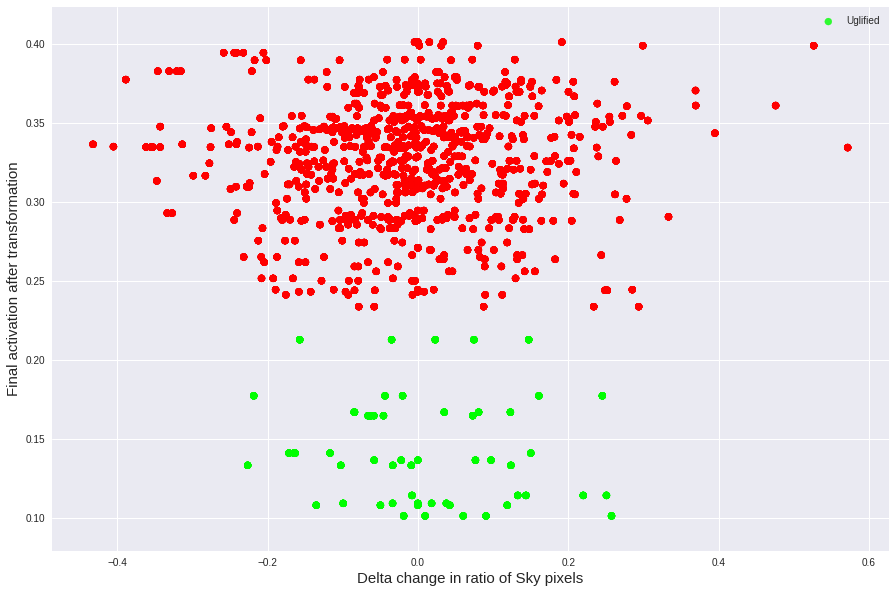

In [176]:
#beautiFied = [labelDeltas[5][i] for i in range
colorPallet=["#FF0000", "#00FF00"]
colors = [colorPallet[action[i]] for i in range(len(action))]
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
plt.xlabel("Delta change in ratio of Sky pixels" , fontsize = 15)
plt.ylabel("Final activation after transformation" , fontsize = 15 )
fig = plt.scatter( labelDeltas[6],acts,  alpha=0.8 , c = colors)
plt.legend(['Uglified' , 'Beautified'])
plt.show()